In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, jit
import matplotlib.pyplot as plt
import joblib
from qdots_qll.models import game
from qdots_qll import all_funcs
import seaborn as sns
import pandas as pd
import scipy
from functools import reduce

In [2]:
import matplotlib.font_manager as font_manager

# Add every font at the specified location
# font_dir = ["/Users/darioradecic/Downloads/Merriweather"]
# for font in font_manager.findSystemFonts(font_dir):
#     font_manager.fontManager.addfont(font)

# font_manager.get_font_names()


from matplotlib import rcParams

rcParams["font.family"] = "Lato"

sns.set_palette("colorblind")

In [3]:
names_true = [
    "$\\gamma ( - \\eta)$",
    "$\\gamma ( + \\eta)$",
    "$S ( - \\eta)$",
    "$S ( +\\eta)$",
]
names_hat = [
    "$\\hat{\\gamma} ( - \\eta)$",
    "$\\hat{\\gamma} ( + \\eta)$",
    "$\\hat{S} ( - \\eta)$",
    "$\\hat{S} ( +\\eta)$",
]

In [12]:
run_results_det_optimized = joblib.load(
    "../results/run_2024-03-05_10:56:26_results.job"
)
run_model_det_optimized = joblib.load(
    "../results/run_2024-03-05_10:56:26_model.job")
m = run_model_det_optimized

In [14]:
true_pars = game.true_pars

number_of_samples = 250

iters = np.arange(0, run_results_det_optimized.estimates_array.shape[1])

In [97]:
run_results_det_optimized

Run(
  iteration=i32[250],
  key=u32[250,2],
  weights=f32[250,2000],
  particles_locations=f32[250,2000,4],
  max_iterations=i32[250],
  min_iterations=i32[250],
  std_threshold=f32[250],
  cov_array=f32[250,6000,4,4],
  estimates_array=f32[250,6000,4],
  times_array=f32[250,6000]
)

In [13]:

m

physical_model(
  number_of_parameters=4,
  delta=0.12739334807998307,
  Omega=0.5,
  H0=f32[2,2],
  A=i32[2,2],
  sic_POVM_arr=c64[16,4,4],
  basis_elements=f32[4,4]
)

In [56]:
times = jnp.linspace(0, 40, 1000)


evolution_fim = jax.vmap(lambda t: m.fim(true_pars, t))(times)
evolution_inverse_fim = jax.vmap(
    lambda t: jnp.linalg.inv(m.fim(true_pars, t))
)(times)

evolution_det_fim = jax.vmap(lambda t: jnp.linalg.det(m.fim(true_pars, t)))(
    times
)

evolution_norm_inverse_fim = jax.vmap(
    lambda t: jnp.linalg.norm(jnp.linalg.inv(m.fim(true_pars, t)))
)(times)

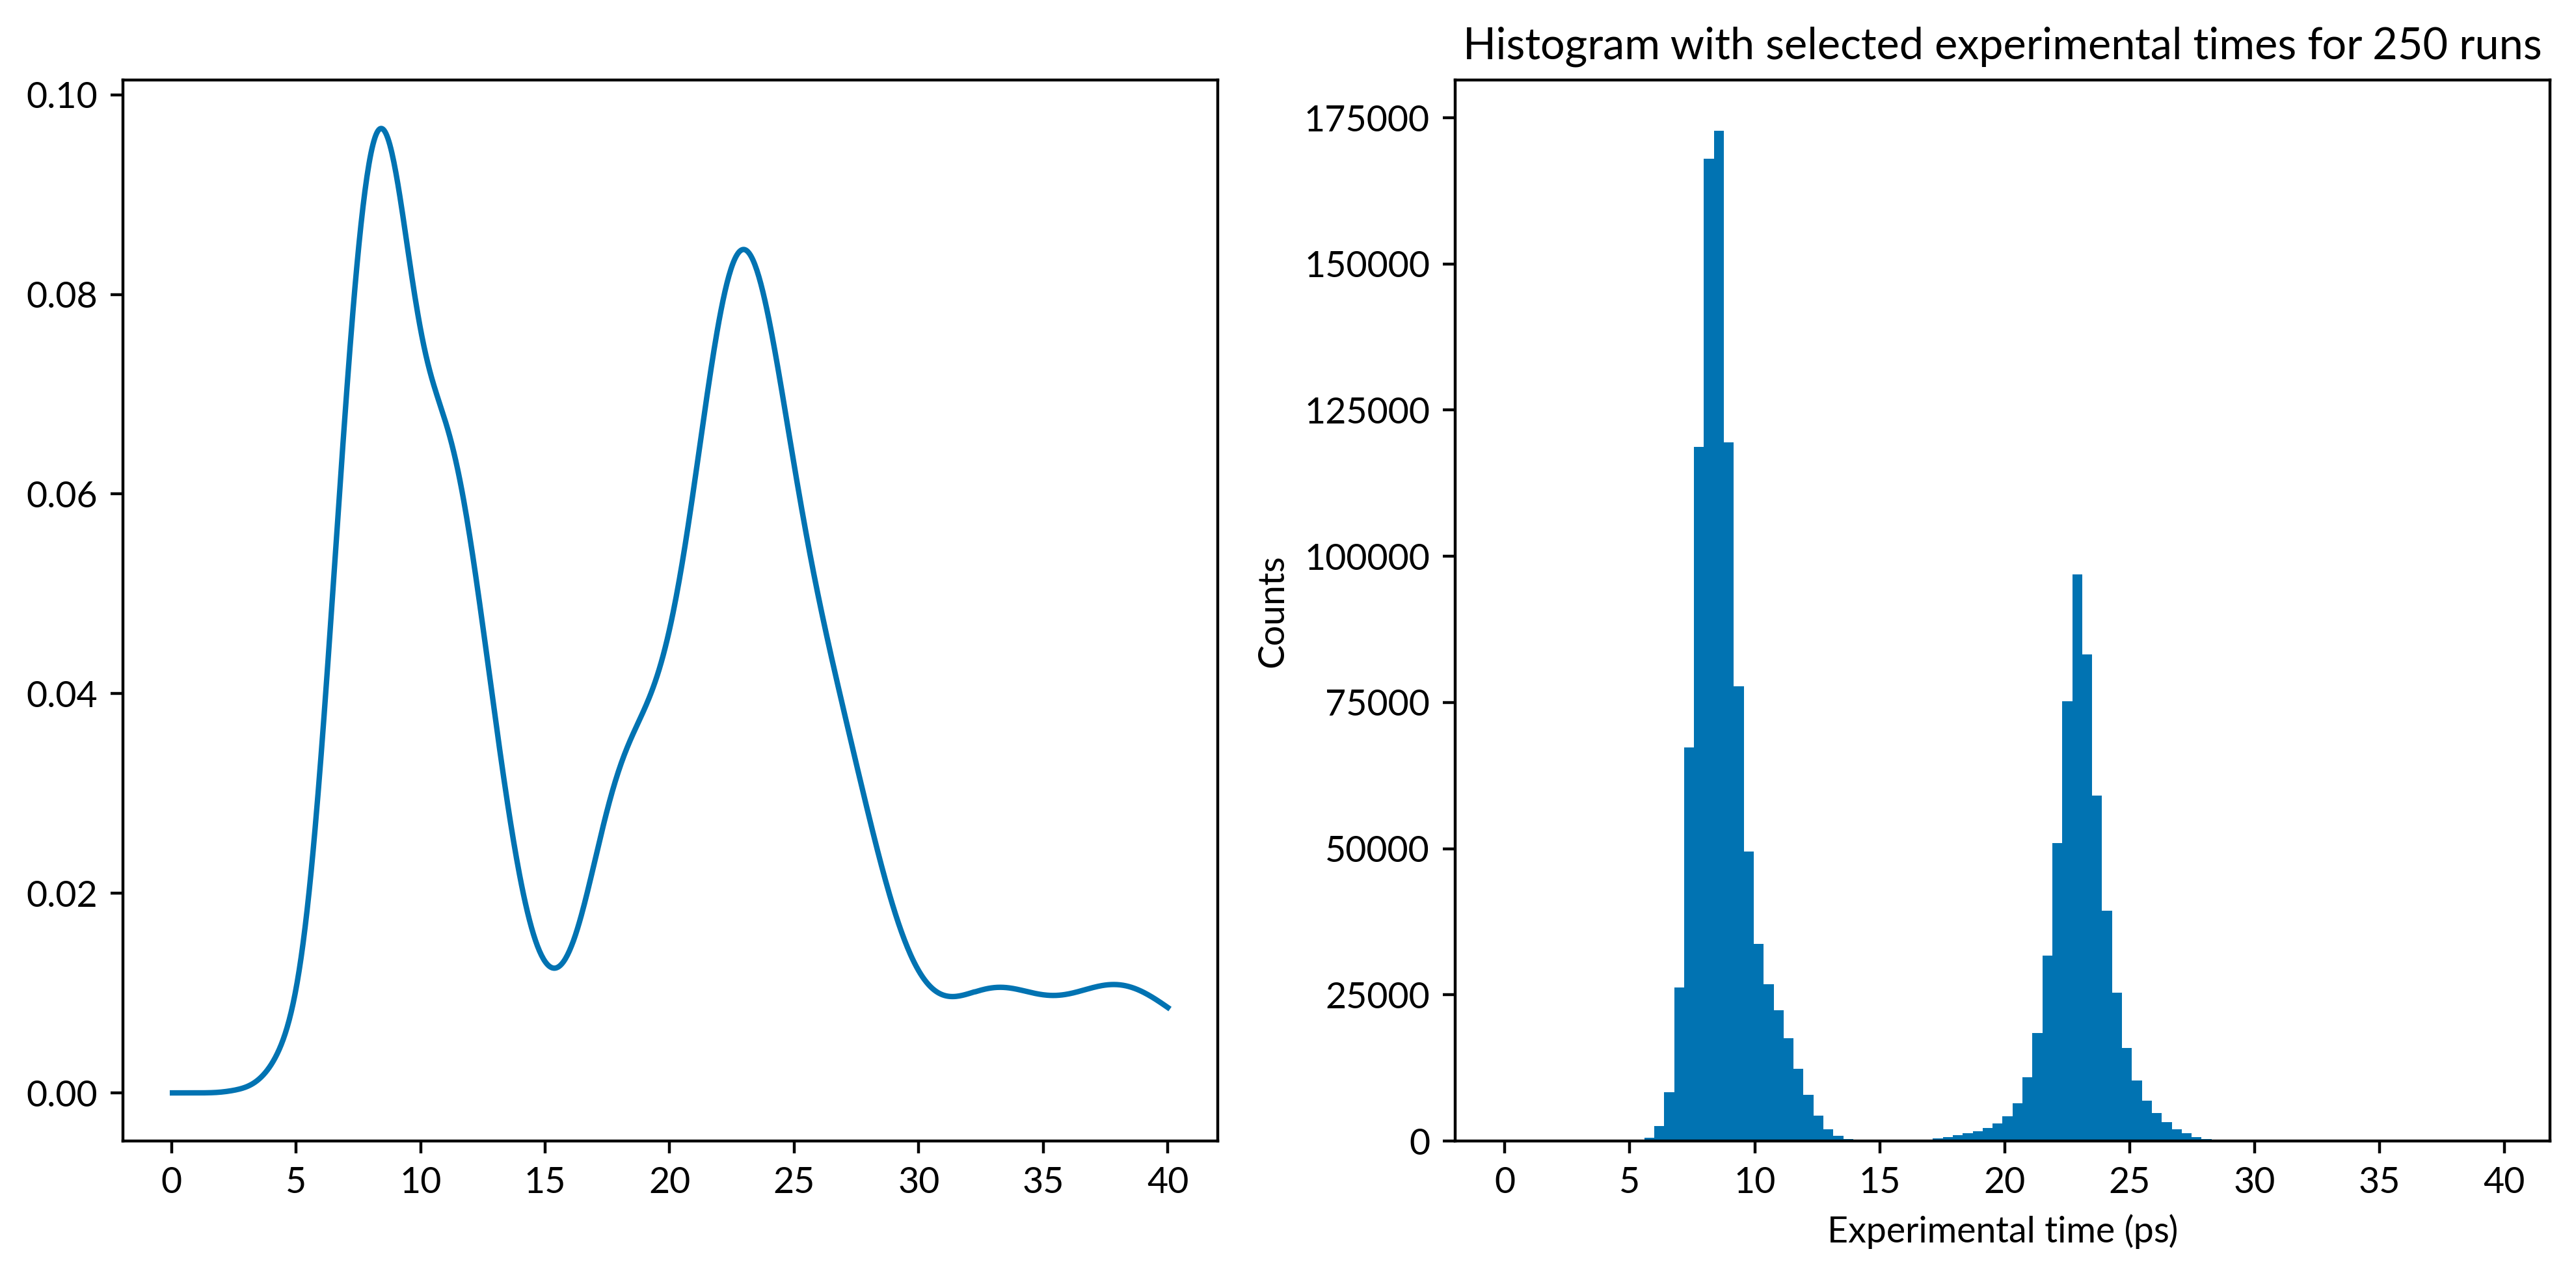

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=400)



ax1.plot(times, evolution_det_fim)


ax2.hist(np.array(run_results_det_optimized.times_array).flatten(), bins=100)
ax2.set_title(f"Histogram with selected experimental times for {number_of_samples} runs")
ax2.set_xlabel("Experimental time (ps)")
ax2.set_ylabel("Counts")

plt.tight_layout()
# plt.show()


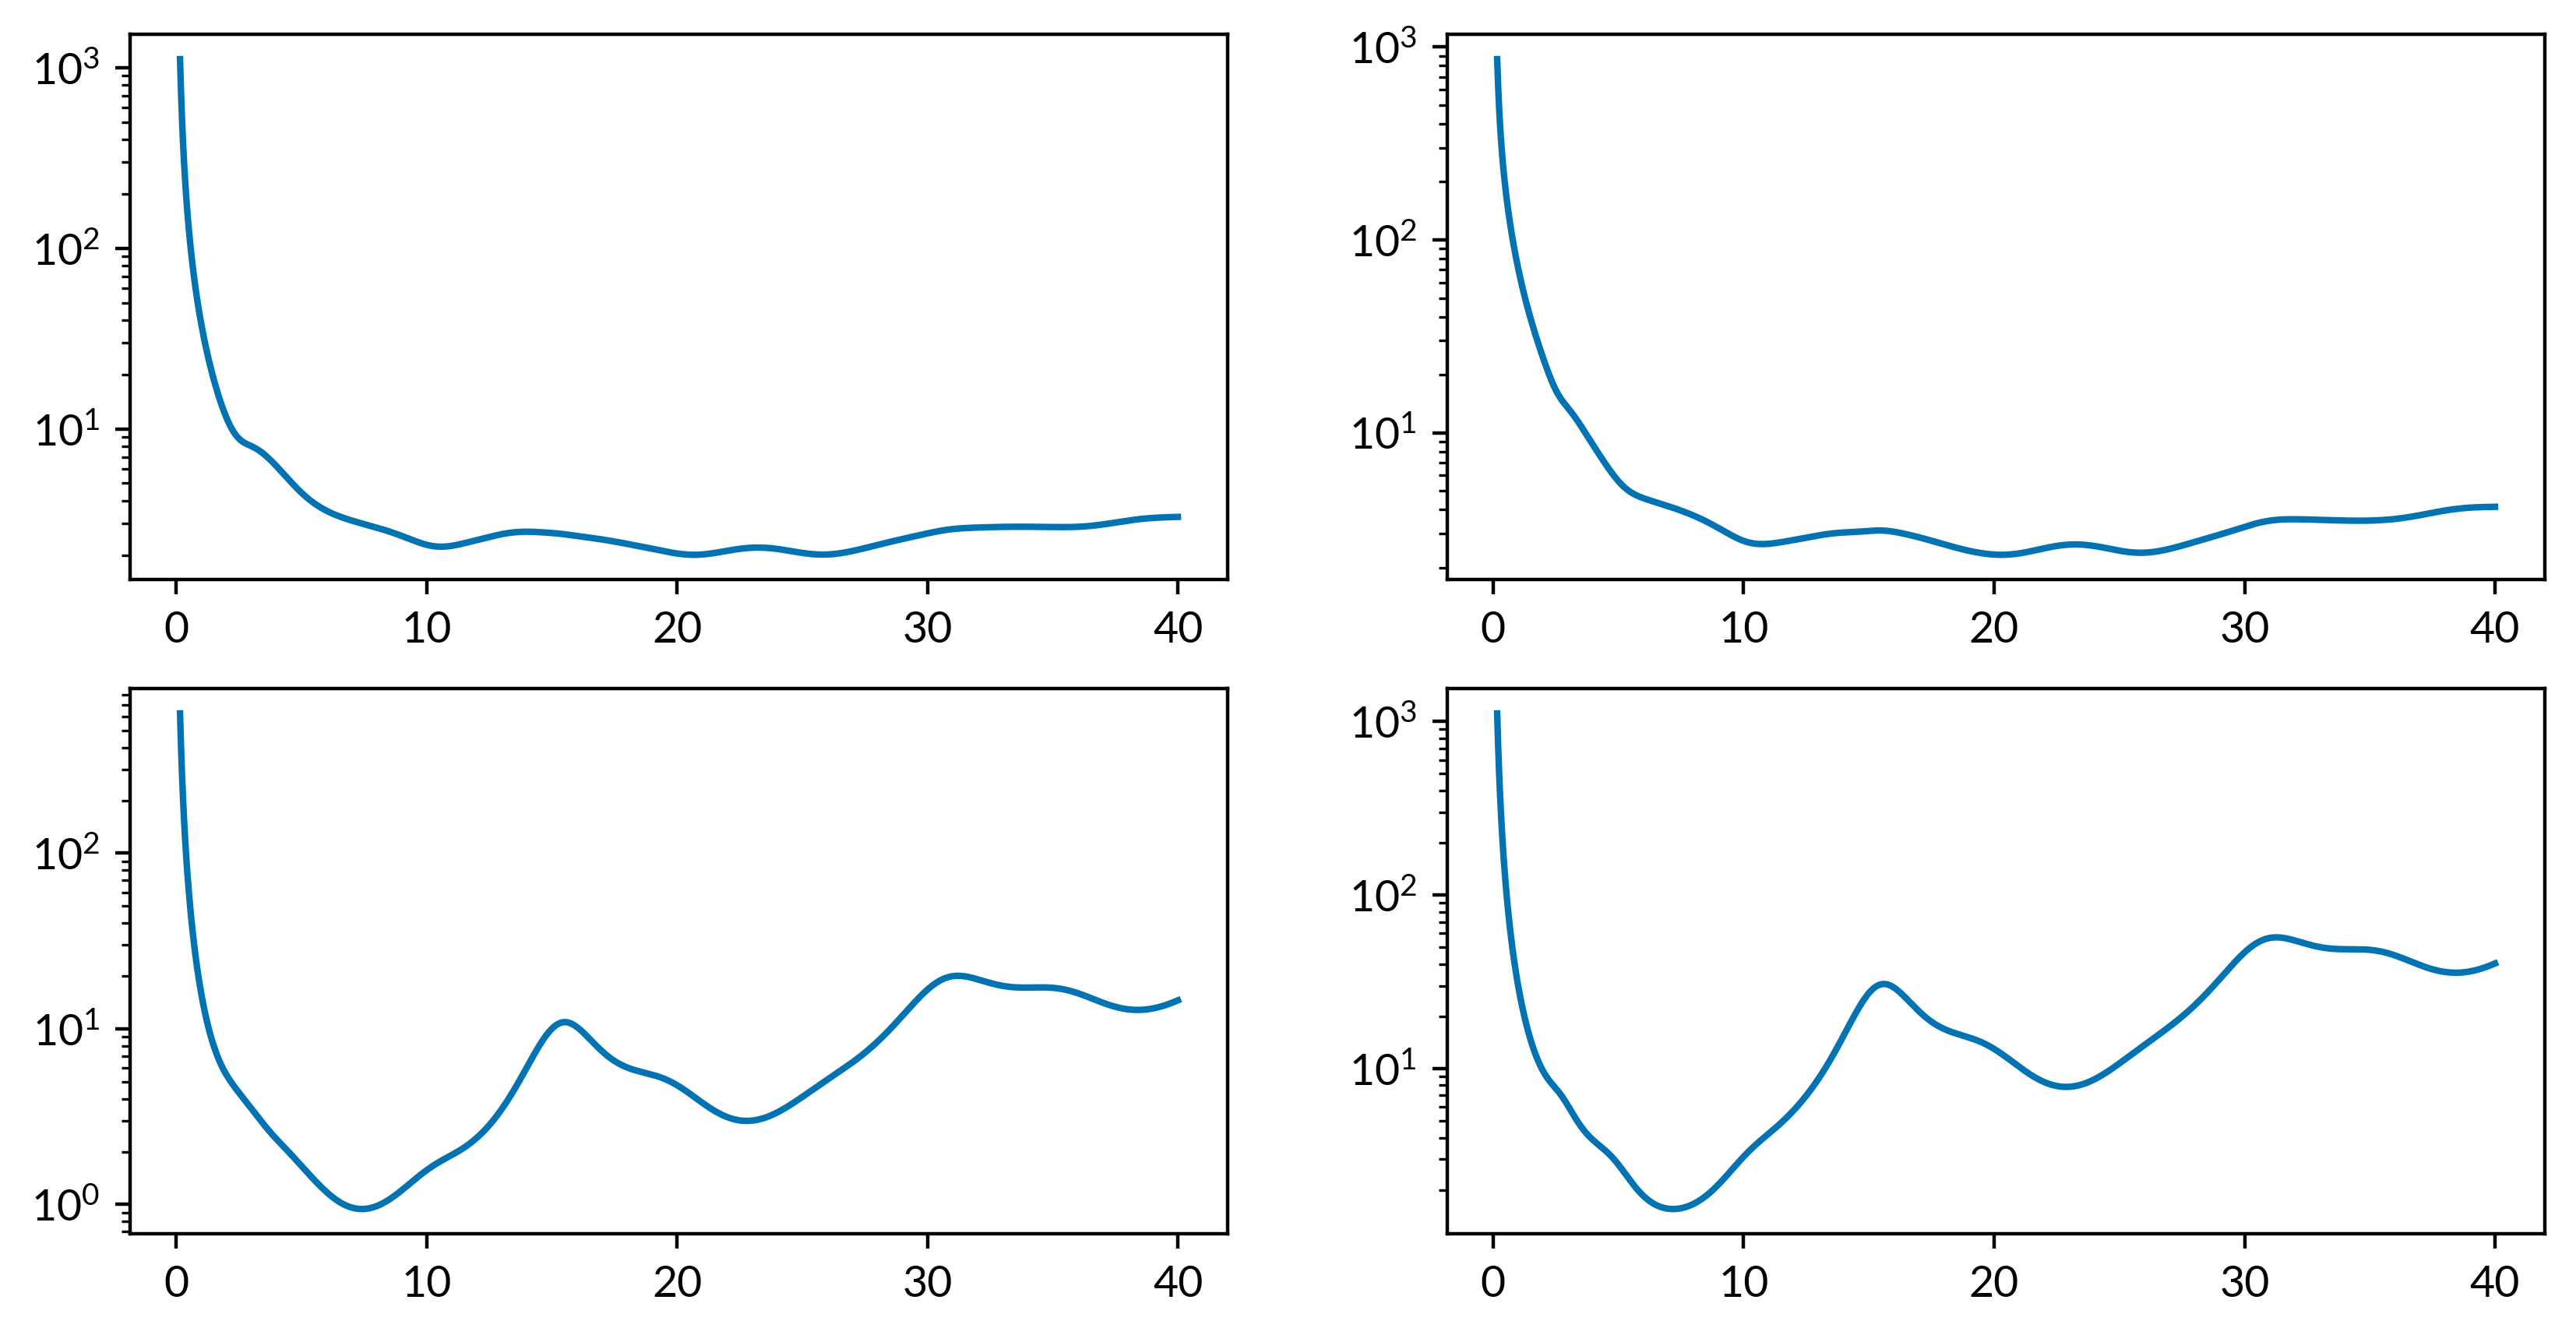

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=400)

for i, ax in enumerate(axs.flat):
    ax.plot(times[4:], evolution_inverse_fim[4:, i, i])
    # ax.set_xscale("log")
    ax.set_yscale("log")



In [49]:
times[np.diag(np.argmin(evolution_inverse_fim[1:], axis=0)) + np.array([1, 1, 1, 1])]  

Array([20.66066  , 20.300299 ,  7.4074073,  7.1671667], dtype=float32)

In [76]:
maxdet = np.nanmax(evolution_det_fim, axis=0)

In [57]:
min_inverse_fim = np.diag(np.nanmin(evolution_inverse_fim[1:], axis=0))

min_inverse_fim

array([2.0092027, 2.327204 , 0.9414389, 1.5490168], dtype=float32)

In [75]:
maxdet

10.349302027154307

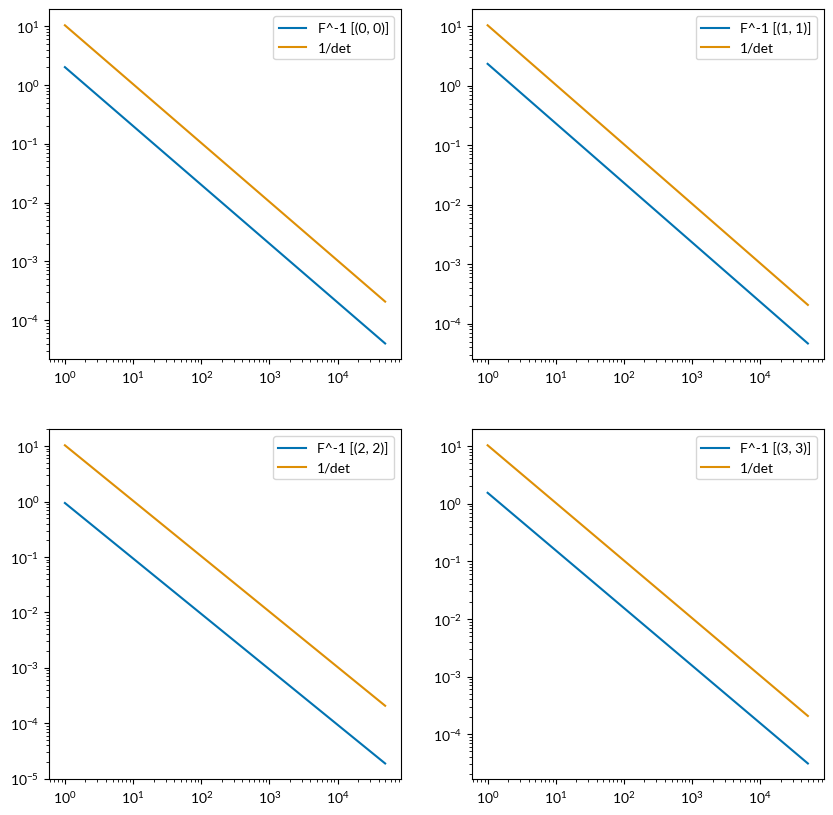

In [99]:
x_for_scaling = np.arange(1, 1e5, 5e4)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.plot(x_for_scaling, 1*min_inverse_fim[i]/x_for_scaling, label=f"F^-1 [{i, i}]")
    ax.plot(x_for_scaling, 1*1/maxdet/x_for_scaling, label="1/det")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

# plt.legend()

In [82]:
df = run_results_det_optimized

cov_arr = df.cov_array[:, 1:]
cumulative_times_per_run = (
    vmap(jnp.cumsum, in_axes=(0))(df.times_array) * 10
)[:, 1:]

var_arr = vmap(vmap(lambda x: jnp.diag(x), in_axes=(0)), in_axes=(0))(cov_arr)

var_arr = np.array(var_arr)
cumulative_times_per_run = np.array(cumulative_times_per_run)

max_lim_bin = int(8.6e5)
no_bins = int(50)
limites_bins = np.arange(
    0.0,
    max_lim_bin,
    np.floor(max_lim_bin / no_bins),
)

In [83]:
def compute_mean_one_run(cum_times_i, cov_arr_i, limites_bins):
    indices_bins = np.digitize(cum_times_i, limites_bins)
    means = np.array(
        [
            np.nanmean(cov_arr_i[indices_bins == i], axis=0)
            for i in range(1, len(limites_bins))
        ]
    )

    std_devs = np.array(
        [
            np.nanstd(cov_arr_i[indices_bins == i], axis=0)
            for i in range(1, len(limites_bins))
        ]
    )
    return means, std_devs

In [84]:
all_mean_stds = np.array(
    [
        compute_mean_one_run(
            cumulative_times_per_run[j], cov_arr[j], limites_bins
        )
        for j in range(len(cov_arr))
    ]
).swapaxes(0, 1)

all_mean_agg_binned = np.nanmean(all_mean_stds, axis=1)[0]
all_std_agg_binned = np.nanstd(all_mean_stds, axis=1)[0]

/tmp/ipykernel_349294/313729249.py:5: RuntimeWarning: Mean of empty slice
  np.nanmean(cov_arr_i[indices_bins == i], axis=0)
/home/antonio/miniconda3/envs/jax_qdots/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [85]:
x_times = np.linspace(0, max_lim_bin, len(all_mean_agg_binned[:]))

/tmp/ipykernel_349294/3527343971.py:6: RuntimeWarning: divide by zero encountered in divide
  1/1 * x_times, 1/1* min_inverse_fim[i] / (1 * 1/1*x_times), label=f"F^-1 [{i, i}]"
/tmp/ipykernel_349294/3527343971.py:8: RuntimeWarning: divide by zero encountered in divide
  ax.plot(1/1 * x_times, 1/1*1 / maxdet / (1 * 1/1*x_times), label="1/det")


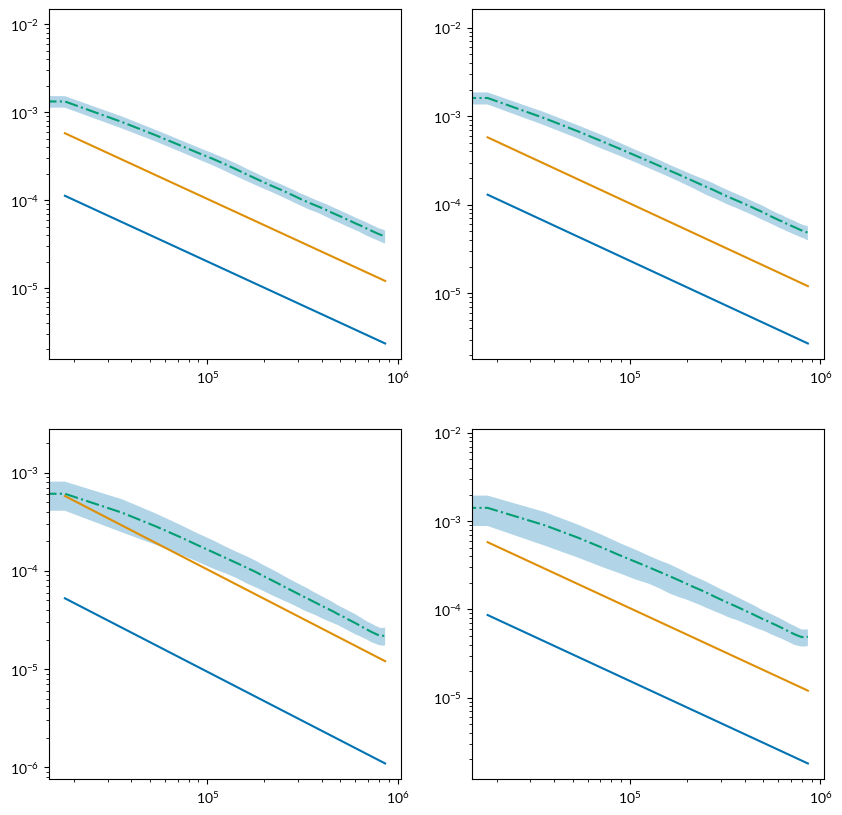

In [106]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):

    ax.plot(
        1/1 * x_times, 1/1* min_inverse_fim[i] / (1 * 1/1*x_times), label=f"F^-1 [{i, i}]"
    )
    ax.plot(1/1 * x_times, 1/1*1 / maxdet / (1 * 1/1*x_times), label="1/det")

    ax.plot(
        x_times,
        all_mean_agg_binned[:, i, i],
        "-.",
    )

    # ax.plot(
    #     x_times,
    #     det_mean_agg_binned[:, i, i],
    #     "-.",
    # )

    # ax.fill_between(
    #     # np.arange(len(all_mean_agg_binned[:, 0, 0])),
    #     np.linspace(0, max_lim_bin, len(det_mean_agg_binned[:, i, i])),
    #     det_mean_agg_binned[:, i, i] - det_std_agg_binned[:, i, i],
    #     det_mean_agg_binned[:, i, i] + det_std_agg_binned[:, i, i],
    #     alpha=0.3,
    # )

    ax.fill_between(
        # np.arange(len(all_mean_agg_binned[:, 0, 0])),
        np.linspace(0, max_lim_bin, len(all_mean_agg_binned[:, i, i])),
        all_mean_agg_binned[:, i, i] - all_std_agg_binned[:, i, i],
        all_mean_agg_binned[:, i, i] + all_std_agg_binned[:, i, i],
        alpha=0.3,
    )
    # ax.plot(x_times, det_opt_scaling)
    # ax.plot(x_times, inverse_matrix_scaling[:, i])
    ax.set_xscale("log")
    ax.set_yscale("log")